# Lab Vision Systems - Learning Vision Systems on Graphics Cards  MA-INF 4308
Ruben Bliersbach

Yihao Wang

Sai Varun Reddy Kamatham 

Table of Contents: 

1. General Information

2. Import Module

3. Datasets
    1. Joint Based
    2. Heatmap Based

4. Models 
    1. Joint Based Models
    2. Heatmap Based Models

Since our codebase is organized as a pip package, you can make it useable by placing this notebook in the root of our project and running the below cell

In [ ]:
%pip install -e .

Normally you should be able to run this notebook without the pip install, but if you want to test any of our scripts, there is no way around.

After you have installed the package please extract the misccellaneous.zip file we provided in the root of the directory and also extract the datasets.zip file into the root directory as well.
If you dont want to download all data, just create a folder datasets/H36Pose in the root of the project and put the original h36m_train.pkl and h36m_validation.pkl inside. We provided a script in src/util/preprocess.py that does the preprocessing and store the results in the correct folder.

## Import Modules

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from src.configs.config import cfg
from src.training.training import load_model
import pickle
import os
from tqdm import tqdm
import random
import numpy as np
import scipy.stats as st
from src.util.visualization import draw_keypoint_sequence,draw_grid_image
import matplotlib.pyplot as plt
%matplotlib inline

f:\Uni\Cuda-Lab\Cuda_Lab\Final_Project\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Utils

In [2]:
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def draw_single_heat(input_frame):
    fig = plt.figure(figsize=(15, 15))
    for f in range(10):
        reference_image = np.zeros((64, 64))
        for i in range(17):
            reference_image = np.add(reference_image, input_frame[1][f][i].numpy())        
        fig.add_subplot(1, 10, f + 1)
        plt.imshow(reference_image)
    plt.show()

## Datasets

In [3]:
from src.data.datasets import Hpose
from src.data.datasetsHeatmap import HposeHeat

### Joint-based Data

In [4]:
validation_dataset = Hpose(subset="valid")
dataloader = DataLoader(validation_dataset, batch_size=2) # you need a batch size of at least 2 since we have a bug in the implementation of the models that does not allow to use a batch size of one

input, gt = next(iter(dataloader))
assert input.shape == gt.shape

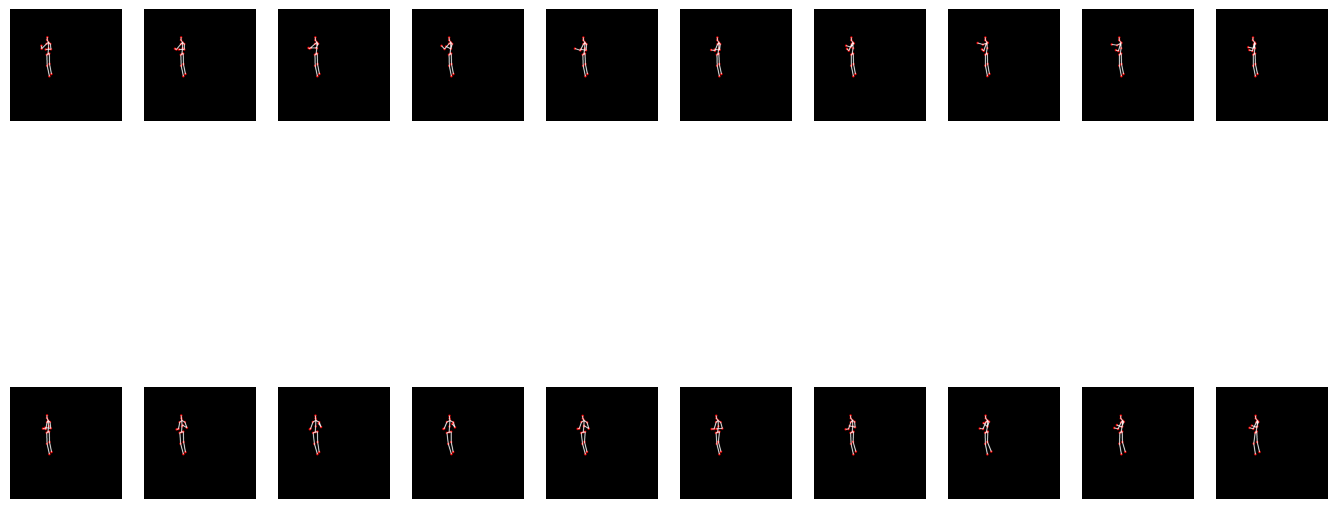

In [5]:
seed_img, gt_img, _ = draw_keypoint_sequence(torch.mul(input, 1000.0), torch.mul(gt, 1000.0), torch.mul(input, 1000.0), 1) # The input is always a batch of tensor and the last parameter is which item in the batch to use for the visualization
whole = torch.cat([seed_img, gt_img])

draw_grid_image(whole, 10, 2)

### Heatmap-based Data

In [6]:
validation_dataset_hm = HposeHeat(subset="valid")
dataloader_hm = DataLoader(validation_dataset_hm, batch_size=2)

input, gt = next(iter(dataloader_hm))
assert input.shape == gt.shape

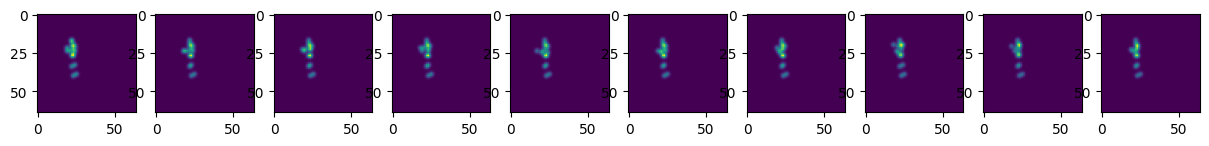

In [7]:
draw_single_heat(input)

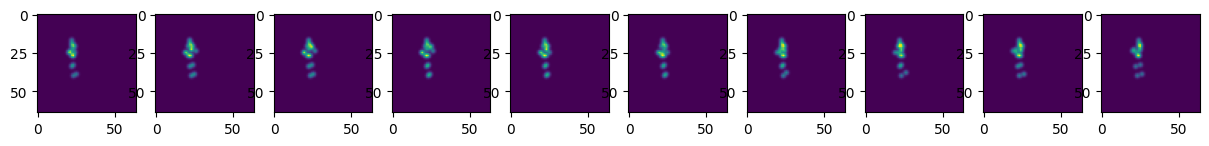

In [8]:
draw_single_heat(gt)

## Models

#### Joint-based models

In [9]:
#import the paths from the paths file
from paths import LSTM_GAN, STATE_SPACE_JOINTS_DIR, AUTOREGRESSIVE_JOINTS_DIR, SEQ2SEQ_JOINTS_DIR
#import models
from src.models.model1 import StateSpaceModel_Cell, AutoregressiveModel_Cell
from src.models.seq2seq import Seq2Seq


state_space = StateSpaceModel_Cell(256,256, residual_connection=False)
state_optimizer = torch.optim.Adam(state_space.parameters())

state_space, state_optimizer, _ = load_model(state_space, state_optimizer, os.path.join(STATE_SPACE_JOINTS_DIR, "best_model.pth"))


autoregressive = AutoregressiveModel_Cell(256,256, residual_connection=False)
autoregressive_optimizer = torch.optim.Adam(autoregressive.parameters())
autoregressive, autoregressive_optimizer, _ = load_model(autoregressive, autoregressive_optimizer, os.path.join(AUTOREGRESSIVE_JOINTS_DIR, "best_model.pth"))



seq_model = Seq2Seq(256)
seq_model_optimizer = torch.optim.Adam(seq_model.parameters())
seq_model, seq_model_optimizer, _ = load_model(seq_model, seq_model_optimizer, os.path.join(SEQ2SEQ_JOINTS_DIR, "best_model.pth"))



generator= Seq2Seq(256)
generator_optimizer = torch.optim.Adam(generator.parameters())
generator, generator_optimizer, _ = load_model(generator, generator_optimizer, os.path.join(LSTM_GAN, "best_model.pth"))


If we now want to do some prediction with our models, we can do it in the following way: 

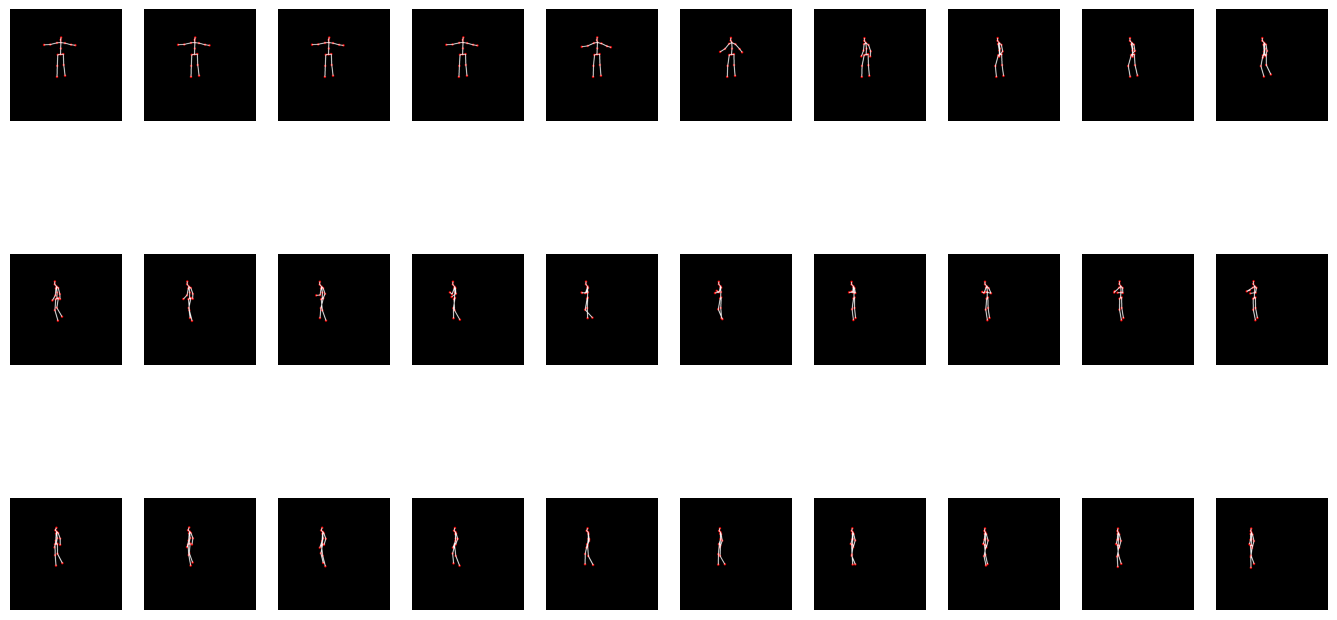

In [10]:
validation_dataset = Hpose(subset="valid")
dataloader = DataLoader(validation_dataset, batch_size=2) # you need a batch size of at least 2 since we have a bug in the implementation of the models that does not allow to use a batch size of one

input, gt = next(iter(dataloader))
assert input.shape == gt.shape

prediction = seq_model(input)

seed_img, gt_img, pred_img = draw_keypoint_sequence(torch.mul(input, 1000.0), torch.mul(gt, 1000.0), torch.mul(prediction, 1000.0), 0)

draw_grid_image(torch.cat([seed_img, gt_img, pred_img]), 10, 3)

#### Heatmap-based models

In [11]:
from paths import CHECKPOINT_DIR, HM_STATE_SPACE_JOINTS_DIR, HM_AUTOREGRESSIVE_JOINTS_DIR, HM_SEQ2SEQ_JOINTS_DIR
from src.models.model3 import StateSpaceModel_Cell, AutoregressiveModel_cell
from src.models.seq2seqhm import Seq2SeqHM

##### State Space Model without residual connection

In [12]:
ss_hm = StateSpaceModel_Cell(encode_dim=128, hidden_dim=128, residual=False)
ss_hm_optimizer = torch.optim.Adam(ss_hm.parameters())
ss_hm, ss_hm_optimizer, _ = load_model(ss_hm, ss_hm_optimizer, os.path.join(HM_STATE_SPACE_JOINTS_DIR, "SS3.pth"))
count_model_params(ss_hm)

2611891

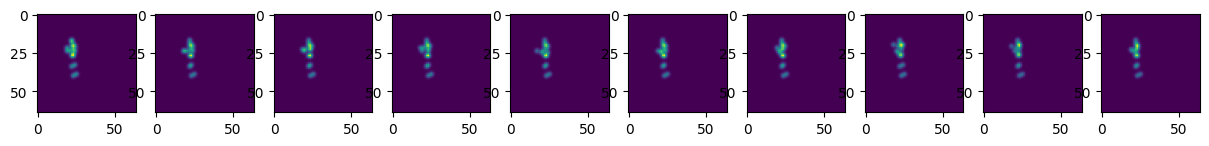

In [13]:
seed, gt = next(iter(dataloader_hm))
prediction = ss_hm(seed)
draw_single_heat(seed)

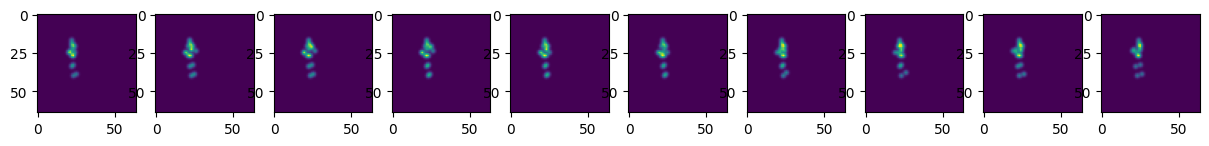

In [14]:
draw_single_heat(gt)

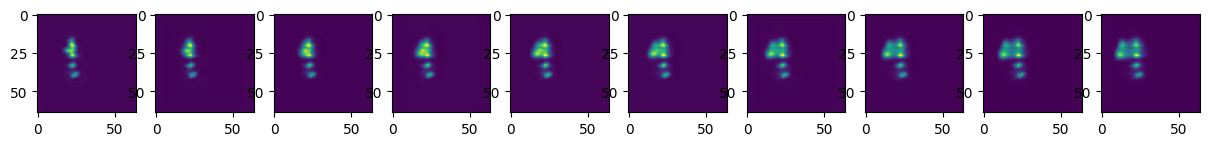

In [15]:
draw_single_heat(prediction.detach())

##### State Space Model with residual connection

In [16]:
ss_hm_res = StateSpaceModel_Cell(encode_dim=128, hidden_dim=128, residual=True)
ss_hm_res_optimizer = torch.optim.Adam(ss_hm_res.parameters())
ss_hm_res, ss_hm_res_optimizer, _ = load_model(ss_hm_res, ss_hm_res_optimizer, os.path.join(HM_STATE_SPACE_JOINTS_DIR, "SS_res_checkpoint_epoch_5.pth"))
count_model_params(ss_hm_res)

2611891

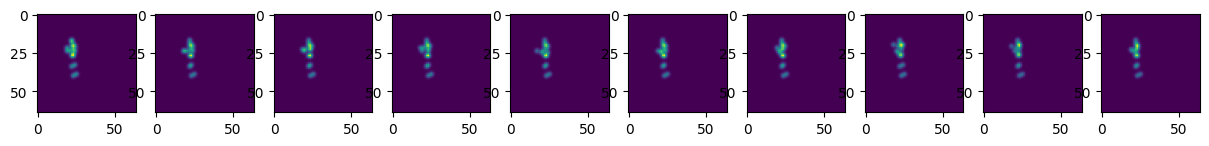

In [17]:
seed, gt = next(iter(dataloader_hm))
prediction = ss_hm_res(seed)
draw_single_heat(seed)

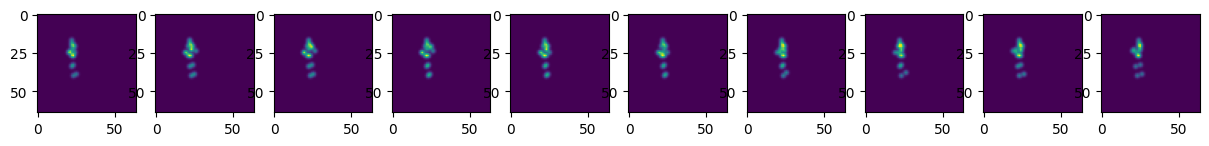

In [18]:
draw_single_heat(gt)

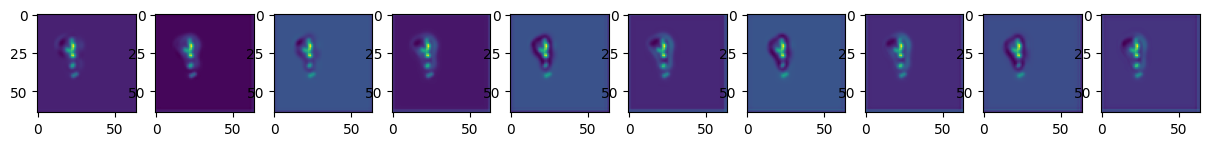

In [19]:
draw_single_heat(prediction.detach())

##### Autoregressive Model

In [20]:
ag = AutoregressiveModel_cell(128,128)
ag_optimizer = torch.optim.Adam(ag.parameters())
ag, ag_optimizer, _ = load_model(ag, ag_optimizer, os.path.join(HM_AUTOREGRESSIVE_JOINTS_DIR, "bestag_15.pth"))
count_model_params(ss_hm)

2611891

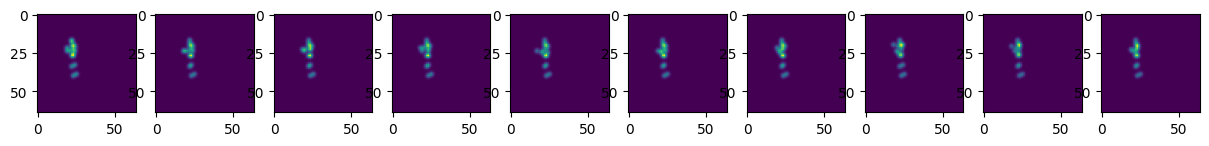

In [21]:
seed, gt = next(iter(dataloader_hm))
prediction = ag(seed)
draw_single_heat(seed)

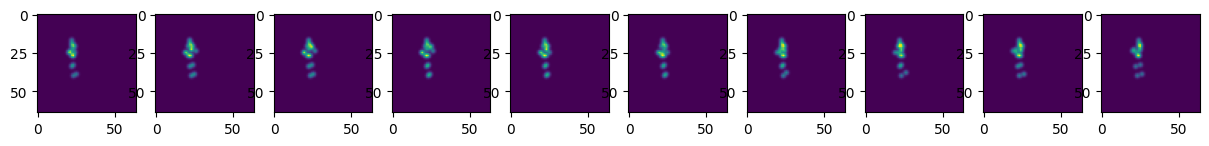

In [22]:
draw_single_heat(gt)

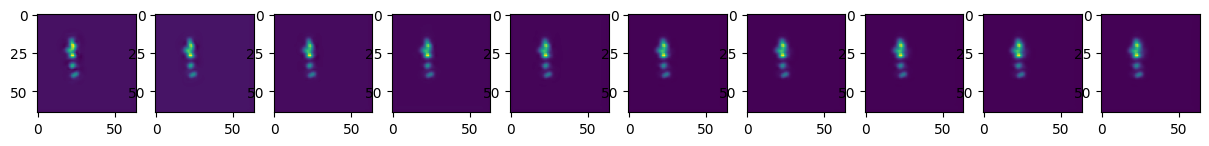

In [23]:
draw_single_heat(prediction.detach())

##### Seq2Seq Model

In [24]:
seq_model = Seq2SeqHM(128)
seq_model_optimizer = torch.optim.Adam(seq_model.parameters())
seq_model, seq_model_optimizer, _ = load_model(seq_model, seq_model_optimizer, os.path.join(HM_SEQ2SEQ_JOINTS_DIR,"S2S_checkpoint_epoch_7.pth"))
count_model_params(seq_model)

4972211

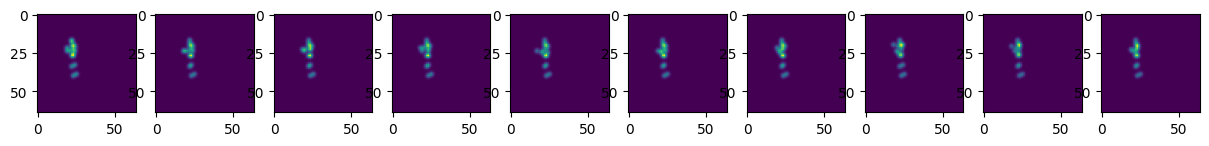

In [25]:
seed, gt = next(iter(dataloader_hm))
prediction = seq_model(seed)
draw_single_heat(seed)

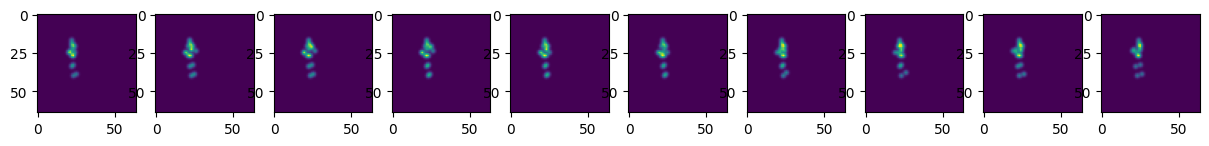

In [26]:
draw_single_heat(gt)

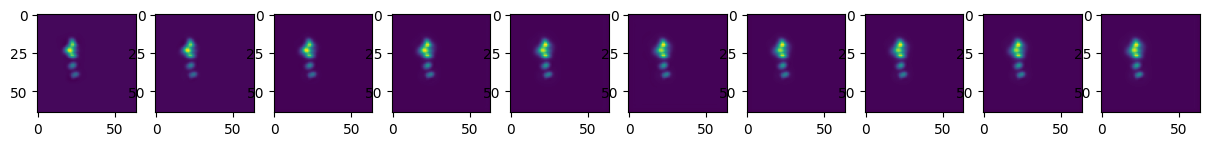

In [27]:
draw_single_heat(prediction.detach())